In [34]:
%pylab inline

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


31.0 31.6210526316


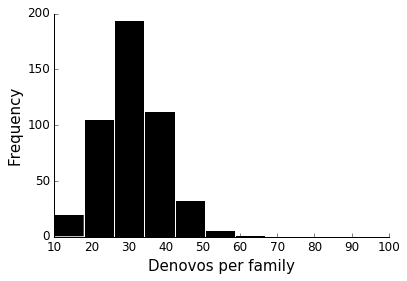

In [33]:
# Plot by family
byfamily = pd.read_csv("../denovos_bylength_byfamily.tab", sep="\t", names=["family","denovos"])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(byfamily["denovos"], color="black", edgecolor="white");
ax.set_xlabel("Denovos per family", size=15);
ax.set_ylabel("Frequency", size=15);
ax.set_xticklabels(map(lambda x: int(x), ax.get_xticks()), size=12);
ax.set_yticklabels(map(lambda x: int(x), ax.get_yticks()), size=12);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
print np.median(byfamily["denovos"]), np.mean(byfamily["denovos"])

In [37]:
# Plot by child for each family
bychild = pd.read_csv("../denovos_bylength_bychild.tab", sep="\t", names=["family","child","status","denovos"])
unaffected = []
affected = []
for family in byfamily["family"]:
    u = bychild[(bychild["family"]==family) & (bychild["status"]==1)]["denovos"].values[0]
    a = bychild[(bychild["family"]==family) & (bychild["status"]==2)]["denovos"].values[0]
    unaffected.append(u)
    affected.append(a)
byfamily["unaffected"] = unaffected
byfamily["affected"] = affected

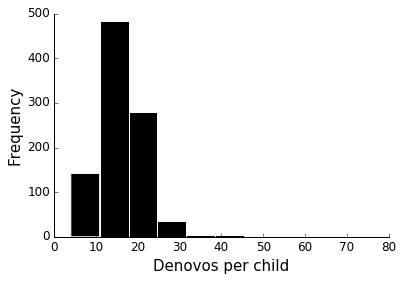

In [19]:
# Histogram of each child
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(bychild["denovos"], color="black", edgecolor="white");
ax.set_xlabel("Denovos per child", size=15);
ax.set_ylabel("Frequency", size=15);
ax.set_xticklabels(map(lambda x: int(x), ax.get_xticks()), size=12);
ax.set_yticklabels(map(lambda x: int(x), ax.get_yticks()), size=12);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

0.0 -0.0842105263158


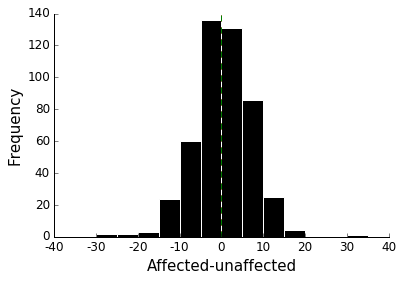

In [26]:
# Histogram of diff in affected-unaffected
fig = plt.figure()
ax = fig.add_subplot(111)
diff = byfamily["affected"]-byfamily["unaffected"]
ax.hist(diff,
        bins = np.arange(-40, 40, 5),
        color="black", edgecolor="white");
ax.set_xlabel("Affected-unaffected", size=15);
ax.set_ylabel("Frequency", size=15);
ax.set_xticklabels(map(lambda x: int(x), ax.get_xticks()), size=12);
ax.set_yticklabels(map(lambda x: int(x), ax.get_yticks()), size=12);
ax.axvline(np.median(diff), color="red", linestyle="dashed")
ax.axvline(np.mean(diff), color="green", linestyle="dashed")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
print np.median(diff), np.mean(diff)

16.0 15.8526315789
15.0 15.7684210526


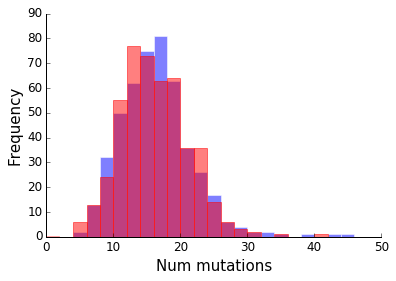

In [31]:
# Histogram of child by status
fig = plt.figure()
ax = fig.add_subplot(111)
bins = np.arange(0, 50, 2)
ax.hist(byfamily["unaffected"], color="blue", edgecolor="white", alpha=0.5, bins=bins);
ax.hist(byfamily["affected"], color="red", edgecolor="red", alpha=0.5, bins=bins);
ax.set_xlabel("Num mutations", size=15);
ax.set_ylabel("Frequency", size=15);
ax.set_xticklabels(map(lambda x: int(x), ax.get_xticks()), size=12);
ax.set_yticklabels(map(lambda x: int(x), ax.get_yticks()), size=12);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
print np.median(byfamily["unaffected"]), np.mean(byfamily["unaffected"])
print np.median(byfamily["affected"]), np.mean(byfamily["affected"])

In [39]:
# Ask if status affects num denovos - paired by family
scipy.stats.ttest_1samp(byfamily["affected"]-byfamily["unaffected"], popmean=0)

Ttest_1sampResult(statistic=-0.25397540904365978, pvalue=0.79962468800944753)

In [44]:
# Ask if status affects num denovos - overall
scipy.stats.ks_2samp(byfamily["affected"],byfamily["unaffected"])

Ks_2sampResult(statistic=0.033684210526315761, pvalue=0.94698642429386759)